# Final Project

Sections:
- [Spark session](#spark_session)
- [Metadata](#metadata)
- [Source Data](#source_data)
- [Clustering](#clustering)

In [1]:
import getpass
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pandas import Series
import datetime
import time

import pandas as pd
import numpy as np

from scipy.stats import gamma, lognorm
import matplotlib.pylab as plt
import seaborn as sns

from pyscripts.test_utils import toy_schedule
from pyscripts.planner import *

from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
%load_ext autoreload
%autoreload 2

<a id='spark_session'></a>
# Spark session


In [2]:
# Initialize spark session
spark = (SparkSession
         .builder
         .appName('final-proj')
         .master('yarn')
         .config('spark.port.maxRetries', 100)
         .config('spark.executor.memory', '1g')
         .config('spark.executor.instances', '2')
         .config('spark.executor.cores', '2')
         .config('spark.jars.packages', 'org.apache.spark:spark-streaming-kafka-0-8_2.11:2.2.0')
         .getOrCreate())

sc = spark.sparkContext
conf = sc.getConf()

spark

<a id='metadata'></a>
# Metadata
The metadata file contains all the stations and gps coordinates.

In [3]:
metadata = spark.read.text('/datasets/project/metadata/BFKOORD_GEO')

We save the information in a Pandas dataframe.

In [4]:
# Splitting and adding new columns to the spark dataframe
split_col = pyspark.sql.functions.split(metadata['value'], " % ")
split_left = pyspark.sql.functions.split(split_col.getItem(0), " +")
metadata = metadata.withColumn('longitude', split_left.getItem(2))
metadata = metadata.withColumn('latitude', split_left.getItem(1))
metadata = metadata.withColumn('stop', split_col.getItem(1))
metadata = metadata.drop('value')

# Save in a Pandas DataFrame
metadataPandas = metadata.toPandas()
metadataPandas.head()

,longitude,latitude,stop
0,44.446770,26.074412,Bucuresti
1,50.901549,1.811446,Calais
2,51.284212,1.075329,Canterbury
3,50.729172,-3.543547,Exeter
4,46.922368,9.733756,"Fideris, Bahnhof"


We only need to keep the stations within 10km from **Zürich HB**. We can compute the distance between two stations using the GPS coordinates.

In [5]:
# Zürich HB is the starting point
zurich_coord = metadataPandas[metadataPandas['stop'] == 'Zürich HB']
zurich_coord

,longitude,latitude,stop
2379,47.378177,8.540192,Zürich HB


In [6]:
# Function to calculate the distance of gps coordinates
def compute_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6371.0 
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance*1000

In [7]:
# keep only stations inside 10km
mask = metadataPandas.apply(lambda x: compute_distance(
    float(zurich_coord['latitude']), 
    float(zurich_coord['longitude']),
    float(x['latitude']), 
    float(x['longitude'])) <= 10000, axis=1)
metadataPandas = metadataPandas[mask]

<a id='source_data'></a>
# Source Data
Open Data Platform Swiss Public Transport (https://opentransportdata.swiss)

In [8]:
# Directory with the source data
df = spark.read.option("delimiter", ";").option("header", "true").csv('/datasets/project/istdaten/*/*')

In [9]:
# Keep only the needed information and rename
df = df.select(
          df['BETRIEBSTAG'].alias('date'), 
          df['FAHRT_BEZEICHNER'].alias('id'), 
          df['PRODUKT_ID'].alias('transport_type'), 
          df['LINIEN_ID'].alias('train_number'), 
          df['HALTESTELLEN_NAME'].alias('stop_name'), 
          df['ANKUNFTSZEIT'].alias('arrival_time'), 
          df['AN_PROGNOSE'].alias('actual_arrival_time'),
          df['AN_PROGNOSE_STATUS'].alias('status_arrival_time'),
          df['ABFAHRTSZEIT'].alias('departure_time'),
          df['AB_PROGNOSE'].alias('actual_departure_time'),
          df['AB_PROGNOSE_STATUS'].alias('status_departure_time'),
          df['DURCHFAHRT_TF'].alias('stop_here'))

First filtering of the dataset and computation of the arrival and departure delays.

In [10]:
# compute the departure and arrival delays
formatTS1 = "dd.MM.yyyy HH:mm:ss"
formatTS2 = "dd.MM.yyyy HH:mm"

departure_delay = (F.unix_timestamp('actual_departure_time', formatTS1) - 
        F.unix_timestamp('departure_time', formatTS2))
arrival_delay = (F.unix_timestamp('actual_arrival_time', formatTS1) - 
        F.unix_timestamp('arrival_time', formatTS2))

# extract the day of the week
def get_week_day(date):
    converted_date = datetime.datetime.strptime(str(date), "%d.%m.%Y")
    return converted_date.weekday()

week_day_udf = F.udf(get_week_day, IntegerType())

# udf to fill NaN departure (arrival) values with the arrival (departure) time
@udf('string')
def fillWithOther(a, b):
    if (a is None):
        return b
    return a
    
# date parser
date = F.to_date('date', 'dd.MM.yyyy')

# First filtering. arrival_delay and departure_delay columns
df_filtered = (df.filter((df.status_arrival_time == 'GESCHAETZT') | (df.status_departure_time == 'GESCHAETZT'))
     .withColumn("arrival_delay", arrival_delay)
     .withColumn("departure_delay", departure_delay)
                      )

# Handling the NaN values
df_with_delays = df_filtered.select('id', 'train_number', 'stop_name', 'arrival_time', 'arrival_delay', 'departure_time', 'departure_delay', 'date')
df_with_delays = df_with_delays.fillna(0, ['departure_delay', 'arrival_delay'])
df_with_delays = (df_with_delays
                  .withColumn('arrival_time2', fillWithOther(df_with_delays.arrival_time, df_with_delays.departure_time))
                  .withColumn('departure_time2', fillWithOther(df_with_delays.departure_time, df_with_delays.arrival_time))
                  .drop(df_with_delays.departure_time).drop(df_with_delays.arrival_time)
                 )
df_with_delays = df_with_delays.withColumnRenamed('departure_time2', 'departure_time').withColumnRenamed('arrival_time2', 'arrival_time')
# Adding the day of the week and the week day of the start of the trip
df_with_delays = df_with_delays.withColumn("day_week_start", week_day_udf(df_with_delays.date))
df_with_delays = df_with_delays.withColumn("day_week", week_day_udf(F.split(df_with_delays.arrival_time, " ")[0]))

# Filtering outliers
df_with_delays = df_with_delays.filter((df_with_delays['arrival_delay'] > -1000) &
                                       (df_with_delays['arrival_delay'] < 1000) &
                                       (df_with_delays['departure_delay'] > -1000) &
                                       (df_with_delays['departure_delay'] < 1000)
                                      )

For each trip id, we need to collect the list of stations. We do it in the following steps:
- Filter the stops that are not in the metadata (i.e. outside 10km).
- Add a new column 'info' containing all the needed information to collect (stop name, arrival time, arrival delay, departure time, departure delay, day of the week).
- Group by trip id.
- Collect the list of the 'info' rows in the group.

In [11]:
df_grouped = (df_with_delays
    .filter(df_with_delays.stop_name.isin(metadataPandas.stop.tolist()))
    .withColumn('info', F.struct('stop_name', F.split('arrival_time', " ")[1], 'arrival_delay', F.split('departure_time', " ")[1], 'departure_delay', 'day_week', 'day_week_start'))
    .groupby('id')
    .agg(F.collect_list('info').alias('info'))
              )

In [12]:
# Collecting the groups
groups = df_grouped.collect()

For each group we collected, we have to compute:
- mean, standard deviation and list of delays for both arrival and departure time
- computing the list of (start_station, arrival_station) couples for each trip (they will be referred as edges)
- discard couples that are incorrect

In [13]:
# Function to compute the delta between departur and arrival time. If the delta is too high, it will be filtered
def compute_delta(arrival, departure, day):
    d1 = datetime.datetime.strptime(arrival, "%H:%M")
    d2 = datetime.datetime.strptime(departure, "%H:%M")
    d1_ts = time.mktime(d1.timetuple())
    d2_ts = time.mktime(d2.timetuple())
    res = int(d2_ts-d1_ts) / 60
    if (day > 0):
        res = res + 60 * 24 * day
    return res

def delays(s):
    return tuple(s)

# DataFrame containing the final schedule
schedule = pd.DataFrame(columns= ['trip_id', 'dep_node', 'arr_node', 
                                  'dep_time', 'arr_time',
                                  'mean_delay', 'std_delay', 
                                  'dep_day', 'arr_day', 'day_start',
                                  'delta', 'delays'])

# Iterating through groups
for group in groups:
    trip_id = group[0]
    info = group[1]
    p = pd.DataFrame(info, columns=['stop', 'arrival_time', 'arrival_delay','departure_time', 'departure_delay', 'week_day', 'day_week_start'])

    # Computing the mean of arrival and departure delays
    c = p.groupby(['week_day', 'arrival_time', 'departure_time', 'stop']).agg([np.mean, np.std, delays])

    c = c.reset_index()
    c.columns = [' '.join(col).strip() for col in c.columns.values]
    
    
    # Creating all the couples of (start_station, arrival_station) for each trip. The order of the schedule 
    # is manteined by the groupby operation. We can have the same schedule for different days of the week, 
    # or the schedule can even change on different days. The compute_delta function calculates the time interval
    # between each couple: if the interval is too high, it means that a new trip started and the couple has to be
    # discarded. We also consider trips that are scheduled between midnight (in this case the week_day changes). 
    partialResult = pd.DataFrame([(trip_id,
                        c.loc[i, 'stop'], 
                        c.loc[i+1, 'stop'], 
                        c.loc[i, 'departure_time'], 
                        c.loc[i+1, 'arrival_time'], 
                        c.loc[i+1, 'arrival_delay mean'],
                        c.loc[i+1, 'arrival_delay std'], 
                        c.loc[i, 'week_day'], 
                        c.loc[i+1, 'week_day'], 
                        c.loc[i, 'day_week_start mean'],
                        compute_delta(c.loc[i, 'departure_time'], 
                                      c.loc[i+1, 'arrival_time'], 
                                      c.loc[i+1, 'week_day']-c.loc[i, 'week_day']),
                        c.loc[i+1, 'arrival_delay delays']) 
                                  for i in range(len(c)-1)],
                     columns= ['trip_id', 'dep_node', 'arr_node', 
                               'dep_time', 'arr_time',
                               'mean_delay', 'std_delay', 
                               'dep_day', 'arr_day', 'day_start', 
                               'delta', 'delays'])
    # Need to merge the last station with the first, in case of a trip that starts on sunday night and finisches
    # on monday morning
    m = len(c)-1
    partialResult = partialResult.append([{'trip_id': trip_id,
                'dep_node': c.loc[m, 'stop'], 
                'arr_node': c.loc[0, 'stop'], 
                'dep_time': c.loc[m, 'departure_time'], 
                'arr_time': c.loc[0, 'arrival_time'],
                'mean_delay': c.loc[m, 'arrival_delay mean'], 
                'std_delay': c.loc[m, 'arrival_delay std'], 
                'dep_day': c.loc[m, 'week_day'], 
                'arr_day': c.loc[0, 'week_day'],
                'day_start': c.loc[m, 'day_week_start mean'],
                'delta': compute_delta(c.loc[m, 'departure_time'], c.loc[0, 'arrival_time'], c.loc[0, 'week_day']+7-c.loc[m, 'week_day']),
                'delays': c.loc[m, 'arrival_delay delays']
                 }], ignore_index=True
               )
    # Filtering the wrong couples and couples where the start and stop stations are the same
    partialResult = partialResult[partialResult.delta < 180]
    partialResult = partialResult[partialResult.dep_node != partialResult.arr_node]
    schedule = schedule.append(partialResult)

schedule.reset_index(drop=True, inplace=True)
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delta,delays
0,85:11:18388:001,Dietlikon,Stettbach,23:14,23:17,60.151515,105.014023,0,0,0,3.0,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ..."
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18,23:22,67.666667,97.935459,0,0,0,4.0,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12..."
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23,23:26,14.606061,92.191695,0,0,0,3.0,"(-45, -41, 125, 354, 143, -25, -40, -39, -38, ..."
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29,23:31,40.606061,38.486150,0,0,0,2.0,"(38, 24, 47, 234, 30, 43, 29, 25, 40, 37, 17, ..."
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31,23:35,3.545455,40.070322,0,0,0,4.0,"(-22, -20, 18, 174, -21, 1, -22, -22, -7, 7, -..."


Dealing with errors.

We found some wrong schedules, always between Zurich HB and Zurich Oerlikon. We suppose that these are errors, because in other days the same schedule doesn't include Zurich Oerlikon.

In [14]:
schedule[(schedule['dep_time'] > schedule['arr_time']) & (schedule['dep_day'] == schedule['arr_day'])].head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delta,delays
1307,85:11:19256:001,Zürich HB,Zürich Oerlikon,15:14,15:12,-66.0,NaN,0,0,0,-2.0,"(-66,)"
4008,85:11:19254:001,Zürich HB,Zürich Oerlikon,14:44,14:42,-139.0,NaN,0,0,0,-2.0,"(-139,)"
15175,85:11:19253:001,Zürich HB,Zürich Oerlikon,14:17,14:16,54.0,NaN,0,0,0,-1.0,"(54,)"
15256,85:11:19285:001,Zürich HB,Zürich Oerlikon,22:17,22:16,156.0,NaN,3,3,3,-1.0,"(156,)"
19164,85:11:19247:001,Zürich HB,Zürich Oerlikon,12:47,12:46,94.0,NaN,0,0,0,-1.0,"(94,)"


In [15]:
# These are the trips that have to be modified
trip_id_to_modify = schedule[(schedule['dep_time'] > schedule['arr_time']) & (schedule['dep_day'] == schedule['arr_day'])]['trip_id']

# Modifying the wrong rows
for i, row in schedule.iterrows():
    if ((schedule.loc[i, 'trip_id'] in list(trip_id_to_modify.values)) &
       (schedule.loc[i, 'arr_node'] == 'Zürich Oerlikon')):
        schedule.loc[i, 'arr_node'] = schedule.loc[i+1, 'arr_node']
        schedule.loc[i, 'arr_time'] = schedule.loc[i+1, 'arr_time']
        schedule.loc[i, 'mean_delay'] = schedule.loc[i+1, 'mean_delay']
        schedule.loc[i, 'std_delay'] = schedule.loc[i+1, 'std_delay']
        
# Eliminating the wrong rows
schedule = schedule[ (~schedule['trip_id'].isin(list(trip_id_to_modify.values)))
        | ((schedule['trip_id'].isin(list(trip_id_to_modify.values)))
           & (schedule['dep_node'] != 'Zürich Oerlikon'  ) )]

In [16]:
# change time type and drop columns
schedule = (schedule.drop(['delta'], axis=1))

def make_time(entry):
    return pd.Timedelta(entry+':00')

schedule['dep_time'] = schedule['dep_time'].apply(lambda x: make_time(x))
schedule['arr_time'] = schedule['arr_time'].apply(lambda x: make_time(x))
          
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays
0,85:11:18388:001,Dietlikon,Stettbach,23:14:00,23:17:00,60.151515,105.014023,0,0,0,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ..."
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18:00,23:22:00,67.666667,97.935459,0,0,0,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12..."
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23:00,23:26:00,14.606061,92.191695,0,0,0,"(-45, -41, 125, 354, 143, -25, -40, -39, -38, ..."
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29:00,23:31:00,40.606061,38.486150,0,0,0,"(38, 24, 47, 234, 30, 43, 29, 25, 40, 37, 17, ..."
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31:00,23:35:00,3.545455,40.070322,0,0,0,"(-22, -20, 18, 174, -21, 1, -22, -22, -7, 7, -..."


Drop edges with **few delays**:

Many edges happened **only few times** (we can see it  from the collected number of delays). To build our schedule we drop all the trips that happened **less times than a treshold** because if a trip took place 10 times over 33 weeks then it is reasonable to not consider it in the schedule. Notice that our schedule has been computed **week-wise** because we want to extract a schedule for each day of the week. Therefore, we won't have a different schedule for special days like Easter or Christmas.

In [17]:
# check how many delays per bus/metro/train edge we have 
# add column with the number of delays per edge
schedule.loc[~schedule.delays.isnull(), "num_delays"] = schedule.delays.loc[~schedule.delays.isnull()].apply(lambda x: np.NaN if x == np.NaN else len(x))
print("Number of delays per bus/metro/train edge:\n", schedule.num_delays.describe())

Number of delays per bus/metro/train edge:
 count    98409.000000
mean        20.071670
std         11.553257
min          1.000000
25%         12.000000
50%         20.000000
75%         32.000000
max         33.000000
Name: num_delays, dtype: float64


In [18]:
# and keep into the schedule only trips happened more than treshold times
treshold = 20
schedule = schedule[schedule.num_delays >= treshold]
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays,num_delays
0,85:11:18388:001,Dietlikon,Stettbach,23:14:00,23:17:00,60.151515,105.014023,0,0,0,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ...",33
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18:00,23:22:00,67.666667,97.935459,0,0,0,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12...",33
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23:00,23:26:00,14.606061,92.191695,0,0,0,"(-45, -41, 125, 354, 143, -25, -40, -39, -38, ...",33
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29:00,23:31:00,40.606061,38.486150,0,0,0,"(38, 24, 47, 234, 30, 43, 29, 25, 40, 37, 17, ...",33
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31:00,23:35:00,3.545455,40.070322,0,0,0,"(-22, -20, 18, 174, -21, 1, -22, -22, -7, 7, -...",33


Estract the **paths** of the trips and add a column indicating the id of the path.

In [19]:
# estract the paths of the trips and add a column indicating the id of the path
def extract_path(x):
    x.dep_node = list(x.dep_node)
    x.arr_node = list(x.arr_node)
    v = x.dep_node
    v.append(x.arr_node[-1])

    return v

# collect the path of each trip_id
paths = (schedule
         .sort_values(["dep_day", "dep_time"])
         .groupby(["trip_id", "day_start"])[["dep_node", "arr_node"]]
         .agg(lambda x: tuple(x))
        )

paths.reset_index(inplace=True)
paths['directed_path'] = paths.apply(func = extract_path, axis=1)
paths.drop(["dep_node", "arr_node"], axis=1, inplace=True)

# give the same order to the nodes of the paths, i.e. A->B->C and C->B->A should be indistinguishable
def undirect(x):
    if x[0] > x[-1]:
        return x[::-1]
    return x

paths["path"] = paths.directed_path.apply(undirect)
paths.path = paths.path.astype("str")
paths.directed_path = paths.directed_path.astype("str")

print("Snapshot of the #trips that share the same path:")
display(paths.groupby("path").count().head())

# map each path to an id
paths["direct_path_id"] = pd.factorize(paths.path)[0]
paths["path_id"] = pd.factorize(paths.path)[0]
paths.set_index("trip_id", inplace=True)
print("Snapshot of the trip ids and repsective paths:")
pd.set_option('display.max_colwidth', -1)
display(paths.head(10))
pd.set_option('display.max_colwidth', 50)

# join the new information to the schedule
schedule = schedule.merge(paths.reset_index()[["trip_id", "day_start", "path_id"]], how="left")

Snapshot of the #trips that share the same path:


,trip_id,day_start,directed_path
path,,,
"['Adliswil', 'Sihlau', 'Wildpark-Höfli']",1,1,1
"['Adliswil', 'Sood-Oberleimbach', 'Zürich Leimbach', 'Zürich Manegg', 'Zürich Brunau', 'Zürich Saalsporthalle', 'Zürich Giesshübel', 'Zürich Selnau', 'Zürich HB SZU']",5,5,5
"['Adliswil', 'Sood-Oberleimbach', 'Zürich Manegg', 'Zürich Brunau', 'Zürich Saalsporthalle', 'Zürich Giesshübel', 'Zürich Selnau', 'Zürich HB SZU']",1,1,1
"['Bonstetten-Wettswil', 'Zürich Altstetten', 'Zürich HB', 'Zürich Oerlikon', 'Wallisellen', 'Dübendorf']",420,420,420
"['Bonstetten-Wettswil', 'Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen', 'Stettbach']",9,9,9


Snapshot of the trip ids and repsective paths:


,day_start,directed_path,path,direct_path_id,path_id
trip_id,,,,,
85:11:13710:001,5,"['Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB']",0,0
85:11:13710:001,6,"['Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB']",0,0
85:11:13711:001,5,"['Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB']",1,1
85:11:13711:001,6,"['Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB']",1,1
85:11:13712:001,5,"['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13712:001,6,"['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13713:001,5,"['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13713:001,6,"['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13714:001,5,"['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2


In [20]:
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays,num_delays,path_id
0,85:11:18388:001,Dietlikon,Stettbach,23:14:00,23:17:00,60.151515,105.014023,0,0,0,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ...",33,2
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18:00,23:22:00,67.666667,97.935459,0,0,0,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12...",33,2
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23:00,23:26:00,14.606061,92.191695,0,0,0,"(-45, -41, 125, 354, 143, -25, -40, -39, -38, ...",33,2
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29:00,23:31:00,40.606061,38.486150,0,0,0,"(38, 24, 47, 234, 30, 43, 29, 25, 40, 37, 17, ...",33,2
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31:00,23:35:00,3.545455,40.070322,0,0,0,"(-22, -20, 18, 174, -21, 1, -22, -22, -7, 7, -...",33,2


In [21]:
# Save the trip paths
paths.to_pickle("data/trip_paths.pkl")

We consider the **walking time** between each station. It can happen that two stations are not connected by any vehicle or that the algorithm choose that is faster to walk instead of waiting for a vehicle.

In [22]:
# Filtering the metadata with the stations we have in the dataset
node_set = list(set(schedule['dep_node']) | set(schedule['arr_node']))
metadata_filtered = metadataPandas[metadataPandas['stop'].isin(node_set)]

In [26]:
# Compute the walking times between stations. Keeping only stations within 500m
walk = pd.DataFrame(columns= ['trip_id', 'dep_node', 'arr_node', 
                              'dep_time', 'arr_time',
                              'mean_delay', 'std_delay', 
                              'dep_day', 'arr_day', 'day_start', 'delays', 'num_delays', 'path_id'])
for _, stop1 in metadata_filtered.iterrows():
    for _, stop2 in metadata_filtered.iterrows():
        if (stop1.stop != stop2.stop):
            distance = compute_distance(float(stop1.latitude), float(stop1.longitude), 
                                       float(stop2.latitude), float(stop2.longitude))
            if (distance <= 500):
                walk = walk.append({'trip_id': '0000', 
                                    'dep_node': stop1.stop, 
                                    'arr_node': stop2.stop, 
                                    'mean_delay': distance, # considering 1m/s of walking speed
                                    'std_delay': 0.0}, ignore_index=True)

walk.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays,num_delays,path_id
0,0000,Zürich HB,Zürich HB SZU,NaN,NaN,140.155394,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0000,Zürich Binz,Zürich Giesshübel,NaN,NaN,381.334098,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0000,Zürich HB SZU,Zürich HB,NaN,NaN,140.155394,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0000,Zürich Giesshübel,Zürich Binz,NaN,NaN,381.334098,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0000,Zürich Manegg,Zürich Leimbach,NaN,NaN,415.434743,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
schedule = schedule.append(walk)

We also compute di distance between each couple of stations and save it in a file. It will be used later in the planner algorithm.

In [32]:
distanceMatrix = metadata_filtered.copy()
for _, i in distanceMatrix.iterrows():
    for _, j in distanceMatrix.iterrows():
        distance = compute_distance(float(i.latitude), float(i.longitude), float(j.latitude), float(j.longitude))
        distanceMatrix.loc[distanceMatrix.stop == i.stop, j.stop] = distance

distanceMatrix = distanceMatrix.drop(["latitude", "longitude"], axis=1).set_index('stop')

In [33]:
distanceMatrix.head()

,Bonstetten-Wettswil,Zürich HB,Zürich Altstetten,Zürich Stadelhofen,Zürich Tiefenbrunnen,Zürich Oerlikon,Zürich Seebach,Zürich Affoltern,Zürich Wollishofen,Zürich Enge,...,Kilchberg,Rüschlikon,Thalwil,Dietlikon,Kloten,Kloten Balsberg,Glattbrugg,Rümlang,Opfikon,Regensdorf-Watt
stop,,,,,,,,,,,,,,,,,,,,,
Bonstetten-Wettswil,0.000000,9858.153857,7573.568223,9987.798035,10700.053799,12648.614390,13287.190924,11373.926812,7649.743793,8133.286627,...,8877.491824,9888.950775,11231.968842,19741.781068,18637.776623,17140.303799,15322.195222,15818.681535,15467.729505,12179.068932
Zürich HB,9858.153857,0.000000,5883.760357,1569.694663,3880.950233,3693.284968,4488.416505,5869.684660,3458.782377,1867.081350,...,5973.699200,7987.109233,9442.450845,9931.379243,9136.575181,7823.200251,6149.094184,8386.080050,6178.028837,9930.500980
Zürich Altstetten,7573.568223,5883.760357,0.000000,7161.755510,9249.391411,6519.274172,6880.776814,3903.660052,6935.717090,5544.194590,...,9874.094756,11842.255847,13467.342901,14830.356759,12275.989954,10670.845149,8894.837135,8431.839555,9136.647151,5301.310988
Zürich Stadelhofen,9987.798035,1569.694663,7161.755510,0.000000,2312.135184,4962.832411,5748.679426,7439.218882,2679.717917,1983.144992,...,4638.719488,6582.227641,7975.337410,9832.022890,9834.431195,8680.604675,7154.421660,9774.413892,7120.179940,11460.839077
Zürich Tiefenbrunnen,10700.053799,3880.950233,9249.391411,2312.135184,0.000000,7019.370389,7771.761171,9750.524035,3103.504734,3730.136866,...,3192.884568,4777.496551,5965.845849,10038.901409,11111.817701,10186.694367,8878.182474,11864.558991,8777.664268,13746.742839


In [34]:
# Checkpoint, save raw schedule and distance matrix in a file
schedule.to_pickle("data/schedule_raw.pkl")
distanceMatrix.to_pickle('data/pairwise_distance.pkl')

In [35]:
schedule = pd.read_pickle("data/schedule_raw.pkl")

schedule.reset_index(drop=True, inplace=True)

# put the walking time in the arrival time
schedule.loc[schedule.trip_id=="0000", "walking_time"] = schedule.loc[schedule.trip_id == "0000", "mean_delay"].apply(lambda secs: pd.Timedelta("00:00:"+str(secs)))

# sort columns and drop mean_delay and std_delay
schedule = schedule[["trip_id", "path_id", "dep_node", "arr_node", "dep_day", "arr_day", "dep_time", "arr_time", "delays", "num_delays", "walking_time"]].copy()

schedule.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ...",33.0,NaT
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12...",33.0,NaT
2,85:11:18388:001,2.0,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-45, -41, 125, 354, 143, -25, -40, -39, -38, ...",33.0,NaT
3,85:11:18388:001,2.0,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(38, 24, 47, 234, 30, 43, 29, 25, 40, 37, 17, ...",33.0,NaT
4,85:11:18388:001,2.0,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-22, -20, 18, 174, -21, 1, -22, -22, -7, 7, -...",33.0,NaT


In [36]:
# separate bus/metro/train edges from walking edges
no_walk = schedule[(schedule.trip_id != "0000")]
walk = schedule[(schedule.trip_id == "0000")]

<a id='clustering'></a>
# Clustering

**Clusterize** all the edges depending on their delays. Edges with similar delays will be associated with the same cluster and each cluster will be associated to a **gamma distribution** initialized with the mean and standart deviation of the delays of the whole cluster. 

We use KMeans to clusterize the edges, however, each edge has between 20 to 33 unordered delays so we extracted the `[20, 30, 40, 50, 60, 70, 80]` qth percentiles for each edge and used them as the features of that edge. This allows to represent more meaningfully the delay distribution of each edge while also dropping some possible outliers.

In [37]:
percentiles = [20, 30, 40, 50, 60, 70, 80]
X = pd.DataFrame(
    columns=percentiles,
)
for p in percentiles:
    X[p] = no_walk.delays.apply(lambda delays: np.percentile(delays, p))
    
X.head()

,20,30,40,50,60,70,80
0,-7.6,-4.4,-2.0,21.0,44.2,72.0,110.6
1,5.0,12.0,13.8,22.0,44.6,59.4,108.8
2,-42.8,-39.4,-37.2,-23.0,-15.4,-2.4,65.2
3,20.4,24.0,29.8,36.0,37.2,41.2,45.8
4,-21.6,-18.2,-16.0,-7.0,3.0,7.4,16.8


Now that we have the features we can run the **KMeans**. Note that the index is the same as the initial dataframe, i.e. we obviously know which percentiles belong to which edge, therefore we can proceed in the clustering. We run KMeans for several number of clusters and plot their respective inertia, i.e. the **within-cluster sum-of-squares**. Then we use the elbow method to choose the more reasonable number of clusters.

Fitting on K=10...
Fitting on K=50...
Fitting on K=100...
Fitting on K=200...
Fitting on K=300...
Fitting on K=500...
Fitting on K=800...


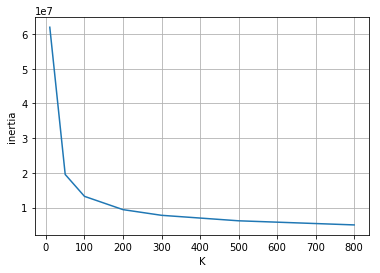

In [38]:
from sklearn.cluster import KMeans

n_clusters = [10, 50, 100, 200, 300, 500, 800]

kmeans = {}
for n_cluster in n_clusters:
    print("Fitting on K="+str(n_cluster) + "...")
    model = KMeans(n_cluster, random_state=0, n_jobs=10)
    kmeans[n_cluster] = model
    
    model.fit(X)

plt.grid()
plt.ylabel("inertia")
plt.xlabel("K")
plt.plot(n_clusters, [model.inertia_ for _, model in kmeans.items()])

In [39]:
# choose the best K and get the corresponding labels
K = 200
X['labels'] = kmeans[K].labels_
X.head()

,20,30,40,50,60,70,80,labels
0,-7.6,-4.4,-2.0,21.0,44.2,72.0,110.6,142
1,5.0,12.0,13.8,22.0,44.6,59.4,108.8,142
2,-42.8,-39.4,-37.2,-23.0,-15.4,-2.4,65.2,181
3,20.4,24.0,29.8,36.0,37.2,41.2,45.8,34
4,-21.6,-18.2,-16.0,-7.0,3.0,7.4,16.8,123


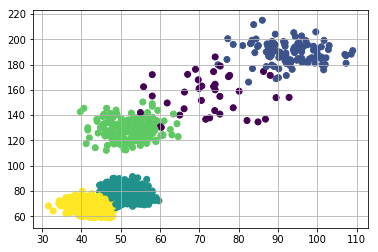

In [40]:
# plot a random subset of the clusters and use only the two percentiles 30 and 70 as dimensions
num_clusters_to_plt = 5
clusters = np.random.choice(K, num_clusters_to_plt, replace=False)
cluster_mapping = dict(zip(clusters, range(num_clusters_to_plt)))

small = X[X['labels'].isin(clusters)].copy()
small['labels'] = small['labels'].apply(lambda label: cluster_mapping[label]) # map the labels to an integer in [0, 1, ..., num_clusters_to_plt-1] so the color is automatically chosen well

plt.grid()
plt.scatter(small[30], small[70], c=small['labels'])

In [41]:
# Adding the cluster label to the schedule
schedule = pd.concat([no_walk, walk], axis=0)
schedule.loc[X.index, "label"] = X["labels"]

schedule.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time,label
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ...",33.0,NaT,142.0
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12...",33.0,NaT,142.0
2,85:11:18388:001,2.0,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-45, -41, 125, 354, 143, -25, -40, -39, -38, ...",33.0,NaT,181.0
3,85:11:18388:001,2.0,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(38, 24, 47, 234, 30, 43, 29, 25, 40, 37, 17, ...",33.0,NaT,34.0
4,85:11:18388:001,2.0,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-22, -20, 18, 174, -21, 1, -22, -22, -7, 7, -...",33.0,NaT,123.0


In [42]:
# Checkpoint
schedule.to_pickle("data/schedule_clustered.pkl")

### Fit a distribution to each cluster

We now create a **distribution** for each cluster and store them in the schedule.
Why?

- We have few samples per edge which may not be representative enough of its delay distribution.
- It is reasonable that some edges' delays are dependent. The clusters have hopefully grouped edges whose delays are jointly dependent.

In [43]:
schedule = pd.read_pickle("data/schedule_clustered.pkl")
schedule.head(1)

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time,label
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ...",33.0,NaT,142.0


- collect **all the delays** for each cluster

In [44]:
# get the labels of the clusters
clusters_labels = sorted(schedule["label"].dropna().astype(int).unique())

# collect all the delays for each cluster
cluster_delays = {} # map cluster -> list fo delays
for c_id in clusters_labels:
    cluster = schedule[schedule["label"] == c_id]
    cluster_delays[c_id] = np.array([delay for edge_delays in cluster.delays for delay in edge_delays])

- **fit a gamma** for each cluster and plot corresponding distributions and histograms

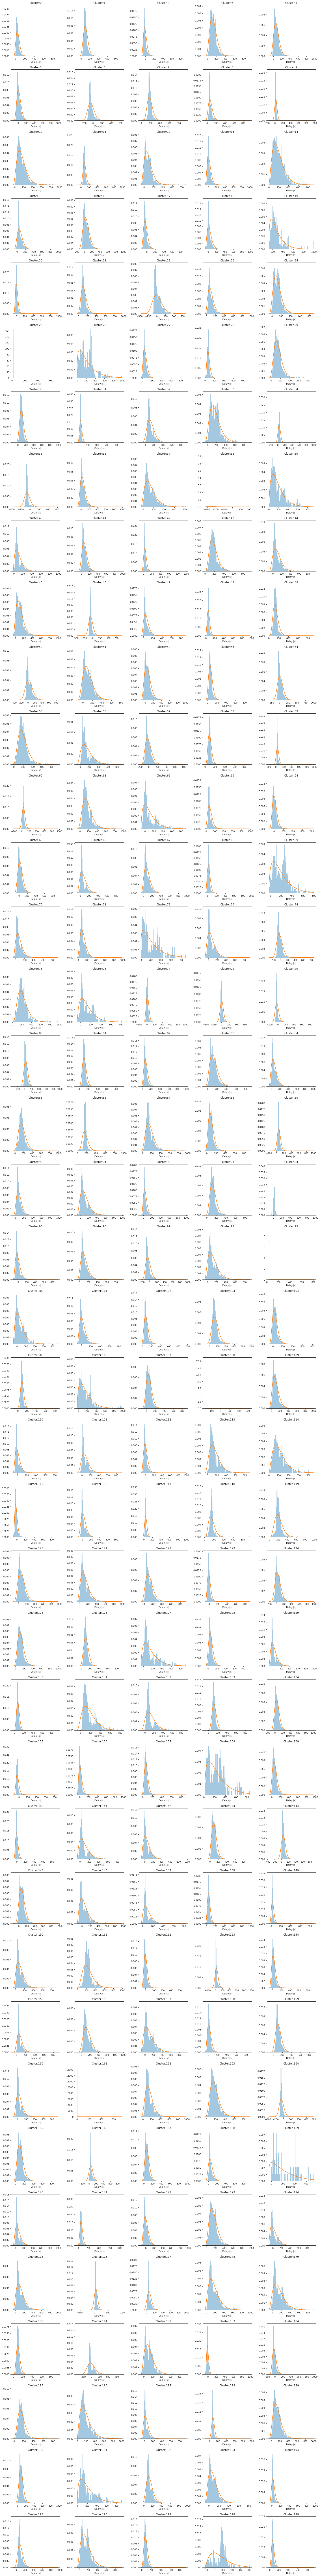

In [45]:
gammas = {} # map cluster label -> gamma distribution

ncols = 5
nrows = 40
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

axs = np.ndenumerate(axs)

for cl, delays in cluster_delays.items():
    
    _, ax = next(axs)
    
    sns.set(color_codes=True)

    # plot histogram
    ax.set(xlabel='Delay [s]')
    sns.distplot(delays, bins=100, kde=False, ax=ax, norm_hist=True)
    
    # fit the gamma on the delays of the cluster
    if cl in [70, 94]:
        # these two clusters are best fitted in this way
        gammas[cl] = gamma(
            *gamma.fit(
                delays,
                loc=delays.min()
            )
        )
    else:
        gammas[cl] = gamma(
            *gamma.fit(
                delays,
                floc=delays.min()-1e-10)
        )

    # plot the gamma's pdf on the same plot
    x = np.linspace(delays.min(),delays.max(),1000)
    ax.plot(x, gammas[cl].pdf(x), label='Gamma distribution')
    ax.set_title("Cluster:" + str(cl))
    
plt.tight_layout()

We can see that the **gammas fit reasonibly well** the delays of the clusters! Let's see the probabilities of the delays being **lower than 5 minutes** (300 seconds):

In [46]:
pd.Series([gamma.cdf(300) for _, gamma in gammas.items()]).describe()

count    200.000000
mean       0.954727
std        0.077912
min        0.636343
25%        0.948094
50%        0.995262
75%        0.999899
max        1.000000
dtype: float64

Most of the probabilities are high, it means that there is often a high probability that the transports do less than 5 minutes of delay and we can safely take a connection whose departure is scheduled 5 minutes after our arrival. 

- add a new column to the `schedule` to **store**, for each edge, **the distribution** of its cluster. Then, store the obtained `schedule`.

In [47]:
for c_id in clusters_labels:
    schedule.loc[schedule["label"] == c_id, "distribution"] = gammas[c_id]
schedule.head(2)

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time,label,distribution
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, -7, 194, 346, 233, 70, -5, 41, 3, 1, -8, ...",33.0,NaT,142.0,<scipy.stats._distn_infrastructure.rv_frozen o...
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 8, 187, 406, 203, 37, -1, 18, 12, 9, 1, 12...",33.0,NaT,142.0,<scipy.stats._distn_infrastructure.rv_frozen o...


In [48]:
# Checkpoint
schedule.to_pickle("data/schedule_clustered.pkl")

## Final clean 
Add/remove the columns to obtain the final DataFrame that will be used by the `Planner`.

In [49]:
schedule = pd.read_pickle("data/schedule_clustered.pkl")

# keep only columns used by the algorithm
schedule = schedule[["trip_id", "path_id", "dep_node", "arr_node", "dep_day", "arr_day", "dep_time", "arr_time", "distribution", "walking_time"]]

# the prob column will store the probability of taking the edge, i.e. of taking a mean of transport at a specific time
schedule["prob"] = np.NaN
# the label column indicates the status of the edge
schedule["label"] = Status.Unvisited
# the prev_edge column indicates the previous edge taken on a path and will allow to reconstruct the whole path
schedule["prev_edge"] = np.NaN

schedule.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
2,85:11:18388:001,2.0,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
3,85:11:18388:001,2.0,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
4,85:11:18388:001,2.0,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN


In [50]:
# Final version of the schedule
schedule.to_pickle("data/schedule_clean.pkl")

# Planner

hypotheses:

    i) given the arcs A->B, if ta_dep < tb_dep => ta_arr < tb_arr (before you depart before you arrive)
    ii) delays distribute with lognorm


simplifications:
    - the number of changes is not taken into account (one would prefer also to take do few stops)

In [51]:
from pyscripts.test_utils import toy_schedule
from pyscripts.planner import *

The source code of the planner can be found in **pyscripts/planner.py**

## Test Planner

In [52]:
schedule = pd.read_pickle("data/schedule_clean.pkl")

# time = pd.Timedelta("4 day 23:59:00")
time = pd.Timedelta("2 day 13:9:00")
start_node = 'Zürich HB'

pl = Planner(schedule, reverse=False)
pl.select_subset_edges(time)
a, b = pl.init_edges(start_node, time)
# print(len(a), len(b))
# pl.edges.loc[pl.walk_ids, "arr_time"] += pd.Timedelta("00:10:00")
best_id = pl.pop_best_edge(a.copy(), b.copy())

display(pl.edges.loc[[best_id]])

ids_tr, ids_walk = pl.expand_edge(best_id, 0.8)

%timeit pl = Planner(schedule, reverse=True)
%timeit pl.select_subset_edges(time)
%timeit a, b = pl.init_edges(start_node, time)
%timeit best_id = pl.pop_best_edge(a.copy(), b.copy(dd))
%timeit ids = pl.expand_edge(best_id, 0.8)

# display(pl.edges.loc[[best_id]])
pl.edges.loc[sorted(ids_tr) + ids_walk]#.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge,nice_direction
8023,0000,NaN,Zürich HB,Zürich HB SZU,2,2,13:09:00,13:11:20,NaN,00:02:20,1.0,Visited,NaN,True


AttributeError: 'Planner' object has no attribute 'visited_paths'

In [ ]:
all_trips = schedule.trip_id.unique()
asd = pd.Series(index=all_trips, data=False)

In [ ]:
schedule = pd.read_pickle("data/schedule_clean.pkl")
walk = schedule[schedule.trip_id == "0000"]
transp = schedule[schedule.trip_id != "0000"]
valid_stations = np.unique(np.append(transp.arr_node.values, transp.dep_node.values))

print(valid_stations.shape)
valid_waks = walk[walk.arr_node.isin(valid_stations) & walk.arr_node.isin(valid_stations)]
print(valid_waks.shape)
valid_waks

In [53]:
schedule = pd.read_pickle("data/schedule_clean.pkl")
pairwise_distances = pd.read_pickle("data/pairwise_distance.pkl")
# pairwise_distances = None

pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=False)

# working:
dep, arr = 'Stettbach', 'Rümlang'
# dep, arr = 'Zürich HB', 'Zürich Stadelhofen'
# dep, arr = 'Zürich HB', "Dübendorf"
# dep, arr = 'Dietlikon', 'Regensdorf-Watt'
# dep, arr = 'Sihlau', 'Zürich HB SZU'
# dep, arr = 'Zürich HB SZU', 'Sihlau'
# dep, arr = 'Zürich HB SZU', 'Zürich HB' 
# dep, arr = 'Zürich HB', 'Adliswil'
# dep, arr = 'Sihlau', 'Zürich HB' 
# dep, arr = 'Zürich H', 'Waldegg, Post'
# dep = 'Adliswil, Eichenweg', 'Zürich HB'
# dep, arr = 'Zürich Altstetten, Bahnhof N', 'Zürich HB'
# dep, arr = "Zürich Landesmuseum (See)", 'Adliswil'
# dep, arr = 'Zürich Binz', 'Zürich Enge'

time = pd.Timedelta("1 day 13:45:00")
treshold = 0.25

path = pl.compute_plan(dep, arr, time, treshold)
# %timeit pl.compute_plan(dep, arr, time, treshold) # 7.42s 8.4s wrt 11.3s (trip pruning)

# print("Path:", last_id)
if path is not None:
    display(pl.edges.loc[path])

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge,nice_direction
21,85:11:18350:001,2.0,Stettbach,Zürich Stadelhofen,1,1,13:48:00,13:52:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,NaN,False
49,85:11:18350:001,2.0,Zürich Stadelhofen,Zürich HB,1,1,13:53:00,13:56:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,21.0,True
122,85:11:2648:001,112.0,Zürich HB,Zürich Oerlikon,1,1,14:01:00,14:07:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,49.0,True
4405,85:11:19518:001,70.0,Zürich Oerlikon,Glattbrugg,2,2,06:00:00,06:02:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,122.0,True
4423,85:11:19518:001,70.0,Glattbrugg,Rümlang,2,2,06:03:00,06:05:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Visited,4405.0,True


In [ ]:
paths = pd.read_pickle("data/trip_paths.pkl")
# pd.set_option('display.max_colwidth', -1)
# display(pd.DataFrame(paths[["path", "path_id"]].drop_duplicates()))
# pd.set_option('display.max_colwidth', 50)

In [ ]:
schedule = pd.read_pickle("data/schedule_clean.pkl")
pairwise_distances = pd.read_pickle("data/pairwise_distance.pkl")

# working:
dep = 'Stettbach'
dep = 'Rümlang'
dep = 'Zürich Stadelhofen'
dep = 'Dübendorf'
dep = 'Regensdorf-Watt'
dep = 'Dietlikon'
dep = 'Sihlau'
dep = 'Zürich HB SZU'
dep = 'Adliswil'
dep = 'Zürich HB' 

time = pd.Timedelta("0 day 13:00:00")
max_time = pd.Timedelta("0 day 15:00:00")
treshold = 0.75

pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=False)
# %timeit reached = pl.compute_isocrone(dep, time, max_time, treshold) #15.5s (1 wrong edge), 20.9s (2 wrong edges)
reached = pl.compute_isocrone(dep, time, max_time, treshold) #15.5 s

# pl = Planner(schedule, pairwise_distances=None, reverse=False)
# %timeit reached = pl.compute_isocrone(dep, time, max_time, treshold) #22.5 s

# reached = pl.compute_isocrone(dep, time, max_time, treshold)

reached

In [ ]:
pd.set_option('max_rows', 1000)
pl.edges.loc[pl.edges.label==Status.Expanded]#, "arr_node"]
# pd.set_option('max_rows', 100)

# Visualization

In [54]:
import yaml
import datetime

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider, HoverTool, LabelSet
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.models.widgets import Dropdown, Select, MultiSelect, TextInput, Toggle, RadioButtonGroup, Div

from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

output_notebook()

# the function that handles the map plotting
def plot_path(doc):
    from bokeh.tile_providers import STAMEN_TERRAIN_RETINA

    # information that we need to plot and/or visualize as labels
    path_stops = pd.DataFrame(columns = ['x', 'y', 'stop', 'departure_time', 'arrival_time'])
    source = ColumnDataSource(path_stops)
    
    tools = "pan,wheel_zoom,reset,save".split(',')
    hover = HoverTool(tooltips=[
        ("Stop", "@stop"),
        ('Departure Time', "@departure_time"),
        ('Arrival Time', "@arrival_time")
    ])
    
    # to show the stops on the map
    labels = LabelSet(x='x', y='y', text='stop', level='glyph',
              source=source, render_mode='canvas')
    
    tools.append(hover)
    
    plot = figure(y_range=(5977000, 6028000), x_range=(960000, 960001),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=950, plot_height=500,
          tools=tools)

    plot.add_layout(labels)
    plot.add_tile(STAMEN_TERRAIN_RETINA)

    # to show stops (circles) and connections (lines)
    plot.circle('x', 'y', source=source, line_width=4)
    plot.line('x', 'y', source=source, line_width=2)
    
    # a button for showing the current computational state of the algorithm
    computation_state = Div(text="")
    
    # wrapper for calling the algorithm to compute the path from the departure station to the destination
    def compute_plan_wrapper(departure_station, destination_station, time, probability_threshold):            
        pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=(real_global_time_flag == 1))
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>WORKING ON</b></font>"
        path = pl.compute_plan(departure_station, destination_station, time, probability_threshold)

        if(path != None):
            proposed_trip = pl.edges.loc[path]

            stops_trip = proposed_trip['dep_node'].copy()
        else:
            stops_trip = np.array([])
        if(stops_trip.shape[0] > 0):
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='green'><b>TERMINATED</b></font>"

            arrival_times = [list(proposed_trip['dep_time'])[0]] + list(proposed_trip['arr_time'])
            departure_times = list(proposed_trip['dep_time']) + [list(proposed_trip['arr_time'])[-1]]
        
            stops_trip['last'] = proposed_trip['arr_node'].values[-1]
            
            a = pd.DataFrame({ 'stop': stops_trip, 'departure_time': departure_times, 'arrival_time': arrival_times }).reset_index()
            a['arrival_time'] = a.arrival_time.map(lambda x: str(x).split(' ')[2])
            a['departure_time'] = a.departure_time.map(lambda x: str(x).split(' ')[2])

            path_stops = a.merge(metadataPandas, on='stop')
            
            # modify the variable created at the beginning of modify_doc
            source.data = ColumnDataSource(data=path_stops).data
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>TERMINATED</b> (no path found)</font>"

    # callback for setting a new departure station    
    def callback_departure(attr, old, new):
        global real_global_dep
        real_global_dep = new
    
    # callback for setting a new destination
    def callback_destination(attr, old, new):
        global real_global_arr
        real_global_arr = new
    
    # callback for setting whether the provided time is desired departure or desired arrival
    def callback_time_flag(attr, old, new):
        global real_global_time_flag
        real_global_time_flag = new
    
    # callback for setting a new departure/arrival time
    def callback_time(attr, old, new):
        try:
            datetime.datetime.strptime(new, '%H:%M:%S')
        except ValueError:
            raise ValueError("Incorrect data format, should be hh:mm:ss")
        day = datetime.datetime.today().weekday()
        global real_global_time
#         real_global_time = pd.Timedelta("0 day 13:00:00")
        real_global_time = pd.Timedelta(str(day) + " day " + new)
            
    # callback for setting a probability threshold
    def callback_threshold(attr, old, new):
        global real_global_threshold
        real_global_threshold = new

    # callback for executing the algorithm
    def callback_execute_algorithm(a):
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>INITIALIZING</b></font>"

        # re-initialize the map
        temp = pd.DataFrame(columns = ['x', 'y', 'stop', 'arrival_time'])
        temp.x = [0]
        temp.y = [0]
        temp.stop = ''
        temp.arrival_time = ''
        source.data = ColumnDataSource(temp).data
        
        if (real_global_dep != None and real_global_arr != None and real_global_time != None and real_global_threshold != None):
            compute_plan_wrapper(real_global_dep, real_global_arr, real_global_time, real_global_threshold)
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>PARAMETERS ERROR</b></font>"

    # define the user interface for executing the algorithm
    stops_in_schedule = np.unique(list(schedule.dep_node.unique()) + list(schedule.arr_node.unique()))
    sorted_stops = sorted(stops_in_schedule)

    # departure station selection menu
    departure = Select(title="Departure Station", options=sorted_stops)
    departure.on_change('value', callback_departure)
    
    # destination selection menu
    destination = Select(title="Destination Station", options=sorted_stops)
    destination.on_change('value', callback_destination)
    
    # choosing whether the provided time is arrival or departure time
    radio_button_group = RadioButtonGroup(
        labels=["Departure Time", "Desired Arrival Time"], active=0)
    radio_button_group.on_change('active', callback_time_flag)
    
    # providing the arrival/departure time
    text_input = TextInput(value="12:00:00", title="Time")
    text_input.on_change('value', callback_time)
    
    # selecting the probability threshold for allowing paths
    slider = Slider(start=0, end=1, value=0, step=0.1, title="Threshold")
    slider.on_change('value', callback_threshold)
    
    # start the algorithm
    button = Toggle(label="Go!", button_type="success")
    button.on_click(callback_execute_algorithm)
    
    doc.add_root(column(departure, destination, radio_button_group, text_input, slider, button, computation_state, plot))
    
handler = FunctionHandler(plot_path)
app = Application(handler)

Loading BokehJS ...

In [56]:
real_global_dep = 'Adliswil'
real_global_arr = 'Adliswil'
real_global_time_flag = 0
real_global_time = pd.Timedelta('12:00:00')
real_global_threshold = 0

show(app, notebook_url="http://10.90.38.21:8945")

There is no path with a probability higher than the given treshold.


In [ ]:
# the function that handles the map plotting
def plot_isochrone_map(doc):
    from bokeh.tile_providers import STAMEN_TERRAIN_RETINA

    # information that we need to plot and/or visualize as labels
    path_stops = pd.DataFrame(columns = ['x', 'y', 'stop', 'arr_time', 'delta'])
    source = ColumnDataSource(path_stops)
    
    tools = "pan,wheel_zoom,reset,save".split(',')
        
    plot = figure(y_range=(5977000, 6028000), x_range=(960000, 960001),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=950, plot_height=500,
          tools=tools)

    plot.add_tile(STAMEN_TERRAIN_RETINA)

    # to show stops (circles) and connections (lines)
    plot.circle('x', 'y', source=source, line_width=0, radius='delta', alpha=0.4, line_alpha=0)
    
    # a button for showing the current computational state of the algorithm
    computation_state = Div(text="")
    
    # wrapper for calling the algorithm to compute the path from the departure station to the destination
    def compute_plan_wrapper(departure_station, start_time, range_minutes, probability_threshold):
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>WORKING ON</b></font>"

        final_time = start_time + pd.Timedelta(minutes=range_minutes)
        pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=False)
        reached = pl.compute_isocrone(departure_station, start_time, final_time, probability_threshold)

        if(reached.shape[0] > 0):
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='green'><b>TERMINATED</b></font>"
            
            reached['delta'] = (final_time - reached['arr_time']).map(lambda x: x.days*24*60 + (x.seconds//60) % 60) * 100
            reached = reached.reset_index()
            reached.columns = ['stop', 'arr_day', 'arr_time', 'delta']
            
            stops = reached.merge(metadataPandas, on='stop')
            
            source.data = ColumnDataSource(data=stops).data
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>TERMINATED</b> (no stations found)</font>"

    # callback for setting a new departure station    
    def callback_departure(attr, old, new):
        global real_global_dep
        real_global_dep = new
    
    # callback for setting a new destination
    def callback_destination(attr, old, new):
        global real_global_arr
        real_global_arr = new
    
    # callback for setting a new departure/arrival time
    def callback_time(attr, old, new):
        try:
            datetime.datetime.strptime(new, '%H:%M:%S')
        except ValueError:
            raise ValueError("Incorrect data format, should be hh:mm:ss")
        day = datetime.datetime.today().weekday()
        global real_global_time
#         real_global_time = pd.Timedelta("0 day 13:00:00")
        real_global_time = pd.Timedelta(str(day) + " day " + new)
            
    def callback_time_range(attr, old, new):
        global real_global_time_range
        real_global_time_range = int(new)
        
    # callback for setting a probability threshold
    def callback_threshold(attr, old, new):
        global real_global_threshold
        real_global_threshold = new

    # callback for executing the algorithm
    def callback_execute_algorithm(a):
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>INITIALIZING</b></font>"

        # re-initialize the map
        temp = pd.DataFrame(columns = ['x', 'y', 'stop', 'arrival_time', 'delta'])
        temp.x = [0]
        temp.y = [0]
        temp.stop = ''
        temp.arrival_time = ''
        source.data = ColumnDataSource(temp).data
        
#         if (real_global_dep != None and real_global_arr != None and real_global_time != None and real_global_threshold != None):
        if (real_global_dep != None and real_global_time_range != None and real_global_time != None and real_global_threshold != None):
            compute_plan_wrapper(real_global_dep, real_global_time, real_global_time_range, real_global_threshold)
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>PARAMETERS ERROR</b></font>"

    # define the user interface for executing the algorithm
    stops_in_schedule = np.unique(list(schedule.dep_node.unique()) + list(schedule.arr_node.unique()))
    sorted_stops = sorted(stops_in_schedule)

    # departure station selection menu
    departure = Select(title="Departure Station", options=sorted_stops)
    departure.on_change('value', callback_departure)
    
    
    # providing the arrival/departure time
    text_input = TextInput(value="12:00:00", title="Time")
    text_input.on_change('value', callback_time)
    
     # providing the time for the area of the isochrone map, in minutes
    text_input = TextInput(value="10", title="Time range (minutes)")
    text_input.on_change('value', callback_time_range)
    
    # selecting the probability threshold for allowing paths
    slider = Slider(start=0, end=1, value=0, step=0.1, title="Threshold")
    slider.on_change('value', callback_threshold)
    
    # start the algorithm
    button = Toggle(label="Show!", button_type="success")
    button.on_click(callback_execute_algorithm)
    
    doc.add_root(column(departure, text_input, slider, button, computation_state, plot))
    
handler_isochrone = FunctionHandler(plot_isochrone_map)
app_isochrone = Application(handler_isochrone)

In [ ]:
real_global_dep = 'Adliswil'
real_global_time = pd.Timedelta('12:00:00')
real_global_time_range = 5
real_global_threshold = 0

show(app_isochrone, notebook_url="http://10.90.38.21:8821")